# Import the libraries that are necesaries

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import getpass  # To get the password without showing the input
from sqlalchemy import create_engine, text
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import nltk
from nltk.corpus import stopwords

Connect to MySQL

In [10]:
password = getpass.getpass()
user = 'root'
database_name = 'steam_games'
connection_string = f'mysql+pymysql://{user}:' + password + '@localhost/' + database_name
engine = create_engine(connection_string)

### Read the CSVs

In [2]:
# # Specify the directory containing the CSV files
# directory_path = '../data/clean/'

# # Specify the order of CSV files
# csv_order = ['game.csv', 'languages.csv', 'platform.csv', 'metacritic.csv', 'user_feedback.csv',
#              'playtime.csv', 'development.csv', 'categorization.csv', 'media.csv']

# # Initialize an empty DataFrame to store the merged result
# game_data = pd.DataFrame()

# # Loop through each CSV file, read it into a DataFrame, and merge it with the existing DataFrame
# for csv_file in csv_order:
#     file_path = os.path.join(directory_path, csv_file)
#     df = pd.read_csv(file_path)

#     # Merge based on the 'appid' column
#     if game_data.empty:
#         game_data = df
#     else:
#         game_data = pd.merge(game_data, df, on='appid', how='outer')

Normalize the dataset

In [ ]:
# # Download NLTK stopwords data
# nltk.download('stopwords')

# # Columns to convert to lists
# columns_to_convert = ['supported_languages', 'full_audio_languages', 'categories', 'genres', 'tags']

# # Create a copy of the original DataFrame
# df_normalized = game_data.copy()

# # Fill NaN values with an empty string
# df_normalized[columns_to_convert] = df_normalized[columns_to_convert].fillna('')

# # Normalize numerical features using StandardScaler
# numerical_columns = df_normalized.select_dtypes(include=['float64', 'int64']).columns.difference(['appid'])
# scaler = StandardScaler()
# df_normalized[numerical_columns] = scaler.fit_transform(df_normalized[numerical_columns])

# # One-hot encode categorical features
# categorical_columns = df_normalized.select_dtypes(include=['bool']).columns.difference(['appid'])
# df_normalized = pd.get_dummies(df_normalized, columns=categorical_columns, drop_first=True)

# # Use CountVectorizer to convert text columns to bag-of-words representation
# count_vectorizer = CountVectorizer(stop_words=stopwords.words('english'))  # Use English stopwords
# for column in columns_to_convert:
#     column_bow = count_vectorizer.fit_transform(df_normalized[column])
#     df_normalized = pd.concat([df_normalized, pd.DataFrame(column_bow.toarray(), columns=count_vectorizer.get_feature_names_out([column]))], axis=1)
#     df_normalized.drop(column, axis=1, inplace=True)

# # Convert 'appid' column to integers
# df_normalized['appid'] = df_normalized['appid'].astype(int)

# df_normalized

# 1. Game Popularity vs. Features:
- *Theory*: Peak concurrent users (peak_ccu) of games are generally higher when their estimated owners are higher.
- *Analysis*: Peak_ccu and estimated owners' correlation with one another.

In [11]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT
                appid,
                estimated_owners,
                peak_ccu
            FROM
                game;'''
    query = text(txt)
    result = connection.execute(query)
    game_df = pd.DataFrame(result.all())

game_df

,appid,estimated_owners,peak_ccu
0,10,15000000.0,13230.0
1,20,7500000.0,110.0
2,30,7500000.0,106.0
3,40,7500000.0,2.0
4,50,7500000.0,120.0
...,...,...,...
85098,2760980,0.0,0.0
85099,2761170,0.0,0.0
85100,2763480,0.0,0.0
85101,2764930,0.0,0.0


In [12]:
# Fill NaN values with an empty string (if needed)
game_df = game_df.fillna('')

# Normalize numerical features using StandardScaler
numerical_columns = game_df.select_dtypes(include=['float64', 'int64']).columns.difference(['appid'])
scaler = StandardScaler()
game_df[numerical_columns] = scaler.fit_transform(game_df[numerical_columns])

In [13]:
game_df

,appid,estimated_owners,peak_ccu
0,10,14.511447,2.423445
1,20,7.213937,-0.004603
2,30,7.213937,-0.005343
3,40,7.213937,-0.024590
4,50,7.213937,-0.002752
...,...,...,...
85098,2760980,-0.083573,-0.024960
85099,2761170,-0.083573,-0.024960
85100,2763480,-0.083573,-0.024960
85101,2764930,-0.083573,-0.024960


In [34]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(game_df[['estimated_owners']], game_df['peak_ccu'], test_size=0.2, random_state=42)

# Fit a linear regression model on the training set
model = LinearRegression().fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Print the coefficients
print(f'Intercept: {model.intercept_}, Coefficient: {model.coef_}')

Mean Squared Error: 1.699260091879029
R-squared: 0.1230291021433676
Intercept: -0.0025204051454137785, Coefficient: [0.51471545]


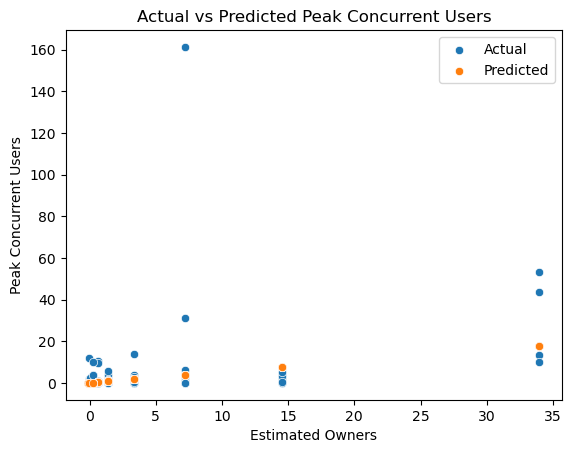

In [38]:
# Scatter plot of actual vs predicted values
sns.scatterplot(x=X_test['estimated_owners'], y=y_test, label='Actual')
sns.scatterplot(x=X_test['estimated_owners'], y=y_pred, label='Predicted')
plt.title('Actual vs Predicted Peak Concurrent Users')
plt.xlabel('Estimated Owners')
plt.ylabel('Peak Concurrent Users')
plt.legend()
plt.show()

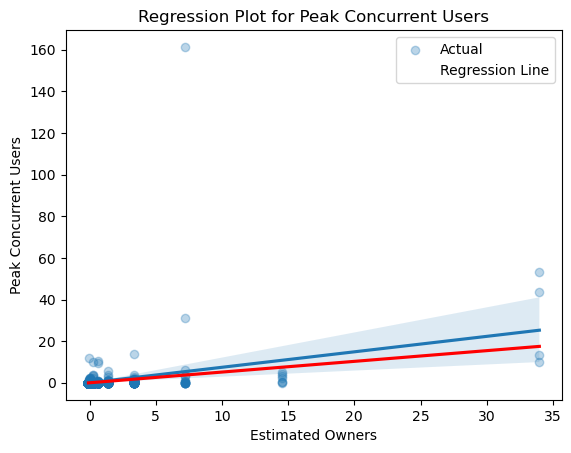

In [37]:
# Regression plot
sns.regplot(x=X_test['estimated_owners'], y=y_test, scatter_kws={'alpha':0.3}, label='Actual')
sns.regplot(x=X_test['estimated_owners'], y=y_pred, scatter_kws={'alpha':0}, line_kws={'color':'red'}, label='Regression Line')
plt.title('Regression Plot for Peak Concurrent Users')
plt.xlabel('Estimated Owners')
plt.ylabel('Peak Concurrent Users')
plt.legend()
plt.show()

# 2. Impact of Platforms on Game Adoption:
- *Theory*: There are more players in games that are accessible on several platforms (Windows, Mac, and Linux).
- *Analysis*: Examine the approximate ownership of games that are accessible across several platforms.

In [56]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT 
                game.estimated_owners, 
                game.peak_ccu, 
                platform.windows, 
                platform.mac, 
                platform.linux
            FROM game
            JOIN platform ON game.appid = platform.appid;'''
    query = text(txt)
    result = connection.execute(query)
    platform_df = pd.DataFrame(result.all())

platform_df

,estimated_owners,peak_ccu,windows,mac,linux
0,15000000.0,13230.0,1,1,1
1,7500000.0,110.0,1,1,1
2,7500000.0,106.0,1,1,1
3,7500000.0,2.0,1,1,1
4,7500000.0,120.0,1,1,1
...,...,...,...,...,...
85098,0.0,0.0,1,0,0
85099,0.0,0.0,1,0,0
85100,0.0,0.0,1,0,0
85101,0.0,0.0,1,0,0


In [57]:
# Normalize numerical features using StandardScaler
numerical_columns = platform_df.select_dtypes(include=['float64', 'int64']).columns.difference(['appid'])
scaler = StandardScaler()
platform_df[numerical_columns] = scaler.fit_transform(platform_df[numerical_columns])

# Concatenate 'windows', 'mac', and 'linux' to create a single feature 'platform'
platform_df['platform'] = platform_df['windows'] + platform_df['mac'] + platform_df['linux']

# Create dummy variables for 'windows', 'mac', and 'linux'
platform_df = pd.get_dummies(platform_df, columns=['windows', 'mac', 'linux'], drop_first=True)

In [58]:
platform_df

,estimated_owners,peak_ccu,platform,windows_0.018778666682752177,mac_2.0472965511682832,linux_2.569279442960615
0,14.511447,2.423445,4.635355,True,True,True
1,7.213937,-0.004603,4.635355,True,True,True
2,7.213937,-0.005343,4.635355,True,True,True
3,7.213937,-0.024590,4.635355,True,True,True
4,7.213937,-0.002752,4.635355,True,True,True
...,...,...,...,...,...,...
85098,-0.083573,-0.024960,-0.858885,True,False,False
85099,-0.083573,-0.024960,-0.858885,True,False,False
85100,-0.083573,-0.024960,-0.858885,True,False,False
85101,-0.083573,-0.024960,-0.858885,True,False,False


In [59]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(platform_df[['platform']], platform_df['estimated_owners'], test_size=0.2, random_state=42)

# Fit a linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Print the coefficients
print(f'Intercept: {linear_model.intercept_}, Coefficient: {linear_model.coef_}')

Mean Squared Error: 0.47632567125510034
R-squared: 0.001264892826967734
Intercept: 0.0016160684322123271, Coefficient: [0.02138766]


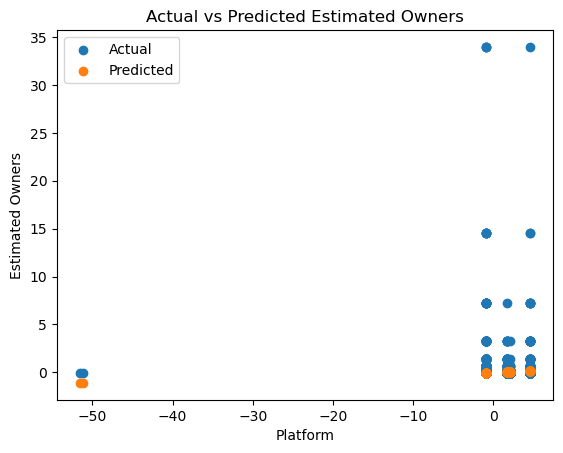

In [60]:
# Scatter plot of actual vs predicted values
plt.scatter(X_test['platform'], y_test, label='Actual')
plt.scatter(X_test['platform'], y_pred, label='Predicted')
plt.title('Actual vs Predicted Estimated Owners')
plt.xlabel('Platform')
plt.ylabel('Estimated Owners')
plt.legend()
plt.show()

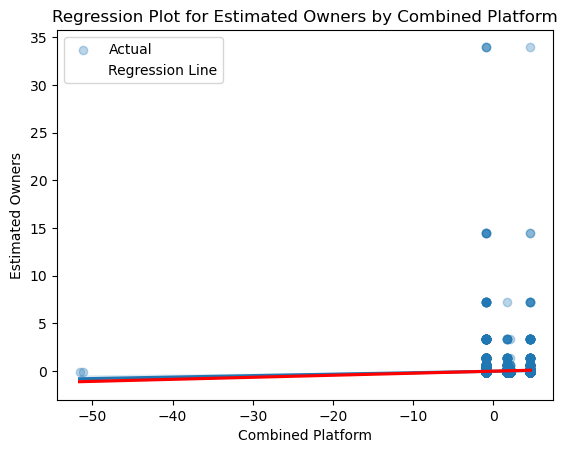

In [61]:
# Regression plot
sns.regplot(x=X_test['platform'], y=y_test, scatter_kws={'alpha': 0.3}, label='Actual')
sns.regplot(x=X_test['platform'], y=y_pred, scatter_kws={'alpha': 0}, line_kws={'color': 'red'}, label='Regression Line')
plt.title('Regression Plot for Estimated Owners by Combined Platform')
plt.xlabel('Combined Platform')
plt.ylabel('Estimated Owners')
plt.legend()
plt.show()

# 3. Metacritic Score and User Feedback:
- *Theory*: The user and Metacritic scores are positively correlated.
- *Analysis*: Comparison of the user_score and metacritic_score correlation.

In [63]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT
                game.appid,
                game.estimated_owners,
                metacritic.metacritic_score,
                user_feedback.user_score
            FROM game
            JOIN metacritic ON game.appid = metacritic.appid
            JOIN user_feedback ON game.appid = user_feedback.appid;'''
    query = text(txt)
    result = connection.execute(query)
    user_score_df = pd.DataFrame(result.all())

user_score_df

,appid,estimated_owners,metacritic_score,user_score
0,10,15000000.0,88.0,0.0
1,20,7500000.0,0.0,0.0
2,30,7500000.0,79.0,0.0
3,40,7500000.0,0.0,0.0
4,50,7500000.0,0.0,0.0
...,...,...,...,...
85098,2760980,0.0,0.0,0.0
85099,2761170,0.0,0.0,0.0
85100,2763480,0.0,0.0,0.0
85101,2764930,0.0,0.0,0.0


In [65]:
# Fill NaN values (if needed)
user_score_df = user_score_df.fillna('')

# Normalize numerical features using StandardScaler
numerical_columns = user_score_df.select_dtypes(include=['float64', 'int64']).columns.difference(['appid'])
scaler = StandardScaler()
user_score_df[numerical_columns] = scaler.fit_transform(user_score_df[numerical_columns])

In [66]:
user_score_df

,appid,estimated_owners,metacritic_score,user_score
0,10,14.511447,5.489238,-0.022235
1,20,7.213937,-0.217125,-0.022235
2,30,7.213937,4.905633,-0.022235
3,40,7.213937,-0.217125,-0.022235
4,50,7.213937,-0.217125,-0.022235
...,...,...,...,...
85098,2760980,-0.083573,-0.217125,-0.022235
85099,2761170,-0.083573,-0.217125,-0.022235
85100,2763480,-0.083573,-0.217125,-0.022235
85101,2764930,-0.083573,-0.217125,-0.022235


In [68]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_normalized[['estimated_owners', 'metacritic_score', 'user_score']], df_normalized['peak_ccu'], test_size=0.2, random_state=42)

# Fit a linear regression model
model_rgr = LinearRegression().fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_rgr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Print the coefficients
print(f'Intercept: {model_rgr.intercept_}, Coefficients: {model_rgr.coef_}')

Mean Squared Error: 0.35551601116229803
R-squared: 0.23122769854229241
Intercept: 4.286747759491108e-05, Coefficients: [ 5.56625073e-01 -4.01503291e-02  1.66639265e-04]


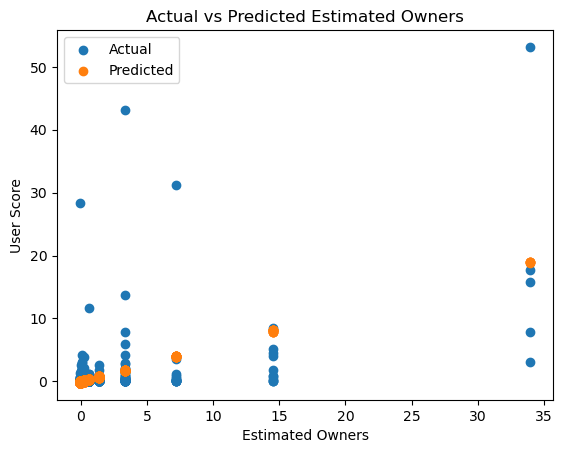

In [71]:
# Scatter plot of actual vs predicted values
plt.scatter(X_test['estimated_owners'], y_test, label='Actual')
plt.scatter(X_test['estimated_owners'], y_pred, label='Predicted')
plt.title('Actual vs Predicted Estimated Owners')
plt.xlabel('Estimated Owners')
plt.ylabel('User Score')
plt.legend()
plt.show()

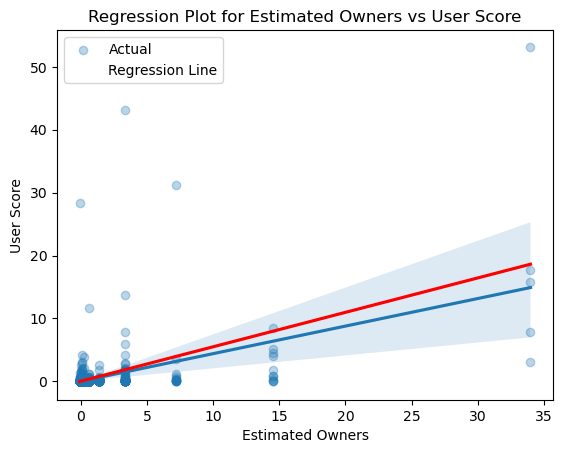

In [72]:
# Regression plot
sns.regplot(x=X_test['estimated_owners'], y=y_test, scatter_kws={'alpha': 0.3}, label='Actual')
sns.regplot(x=X_test['estimated_owners'], y=y_pred, scatter_kws={'alpha': 0}, line_kws={'color': 'red'}, label='Regression Line')
plt.title('Regression Plot for Estimated Owners vs User Score')
plt.xlabel('Estimated Owners')
plt.ylabel('User Score')
plt.legend()
plt.show()

# 4. Effect of Game Features on Reviews:
- *Theory*: There are more achievements in games that have received favorable reviews.
- *Analysis*: Examine the typical quantity of achievements in games that have both favorable and unfavorable evaluations.

In [79]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT
                positive,
                negative,
                achievements
            FROM user_feedback;'''
    query = text(txt)
    result = connection.execute(query)
    feedback_df = pd.DataFrame(result.all())

feedback_df

,positive,negative,achievements
0,198387.0,5135.0,0.0
1,5677.0,923.0,0.0
2,5179.0,566.0,0.0
3,1929.0,428.0,0.0
4,14333.0,718.0,0.0
...,...,...,...
85098,0.0,0.0,0.0
85099,0.0,0.0,0.0
85100,0.0,0.0,0.0
85101,0.0,0.0,0.0


In [80]:
# Fill NaN values with an empty string (if needed)
feedback_df = feedback_df.fillna('')

# Normalize numerical features using StandardScaler
numerical_columns = feedback_df.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
feedback_df[numerical_columns] = scaler.fit_transform(feedback_df[numerical_columns])

In [81]:
feedback_df

,positive,negative,achievements
0,8.104929,1.087587,-0.115835
1,0.193704,0.166842,-0.115835
2,0.173260,0.088801,-0.115835
3,0.039839,0.058635,-0.115835
4,0.549054,0.122029,-0.115835
...,...,...,...
85098,-0.039351,-0.034926,-0.115835
85099,-0.039351,-0.034926,-0.115835
85100,-0.039351,-0.034926,-0.115835
85101,-0.039351,-0.034926,-0.115835


In [82]:
# Split the data into features (X) and target variable (y)
X = feedback_df[['positive', 'negative']]
y = feedback_df['achievements']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Print the coefficients
print(f'Intercept: {model.intercept_}, Coefficients: {model.coef_}')

Mean Squared Error: 0.8252720874738793
R-squared: 0.00018398429207078237
Intercept: 0.0010477197694451017, Coefficients: [ 0.01382648 -0.00190544]


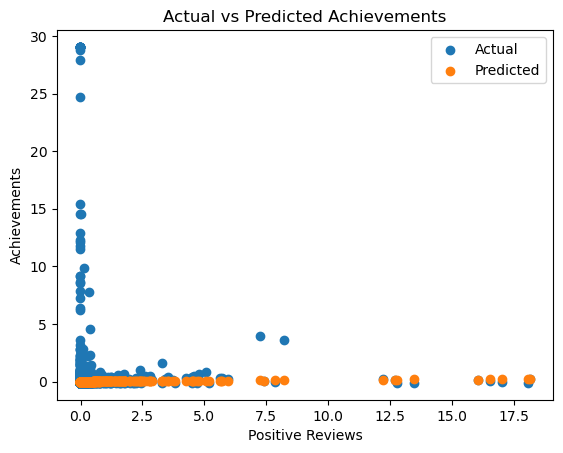

In [83]:
# Scatter plot of actual vs predicted values
plt.scatter(X_test['positive'], y_test, label='Actual')
plt.scatter(X_test['positive'], y_pred, label='Predicted')
plt.title('Actual vs Predicted Achievements')
plt.xlabel('Positive Reviews')
plt.ylabel('Achievements')
plt.legend()
plt.show()

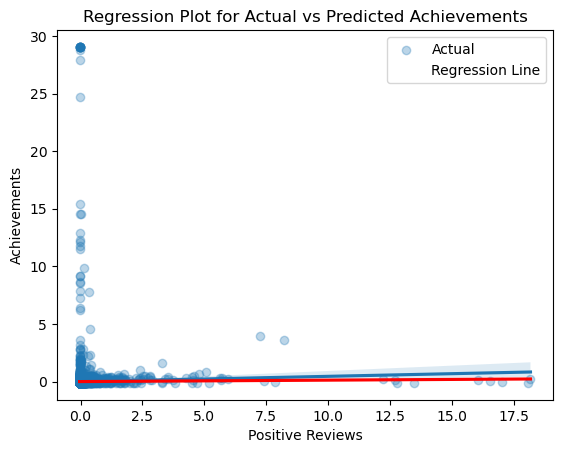

In [84]:
# Regression plot
sns.regplot(x=X_test['positive'], y=y_test, scatter_kws={'alpha': 0.3}, label='Actual')
sns.regplot(x=X_test['positive'], y=y_pred, scatter_kws={'alpha': 0}, line_kws={'color': 'red'}, label='Regression Line')
plt.title('Regression Plot for Actual vs Predicted Achievements')
plt.xlabel('Positive Reviews')
plt.ylabel('Achievements')
plt.legend()
plt.show()

# 5. Playtime Patterns:
- *Theory*: Games with longer median playtimes also have longer average playtimes.
- *Analysis*: Comparison of average_playtime_forever and median_playtime_forever by correlation analysis.

In [90]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT
                appid,
                average_playtime_forever,
                median_playtime_forever
            FROM
                playtime;'''
    query = text(txt)
    result = connection.execute(query)
    playtime_df = pd.DataFrame(result.all())

playtime_df

,appid,average_playtime_forever,median_playtime_forever
0,10,10524.0,228.0
1,20,143.0,23.0
2,30,1397.0,27.0
3,40,945.0,10.0
4,50,214.0,66.0
...,...,...,...
85098,2760980,0.0,0.0
85099,2761170,0.0,0.0
85100,2763480,0.0,0.0
85101,2764930,0.0,0.0


In [91]:
# Fill NaN values with an empty string (if needed)
playtime_df = playtime_df.fillna('')

# Normalize numerical features using StandardScaler
numerical_columns = playtime_df.select_dtypes(include=['float64', 'int64']).columns.difference(['appid'])
scaler = StandardScaler()
playtime_df[numerical_columns] = scaler.fit_transform(playtime_df[numerical_columns])

In [92]:
playtime_df

,appid,average_playtime_forever,median_playtime_forever
0,10,9.120184,0.089152
1,20,0.033499,-0.046545
2,30,1.131149,-0.043897
3,40,0.735504,-0.055150
4,50,0.095646,-0.018081
...,...,...,...
85098,2760980,-0.091672,-0.061769
85099,2761170,-0.091672,-0.061769
85100,2763480,-0.091672,-0.061769
85101,2764930,-0.091672,-0.061769


In [93]:
# Split the data into features (X) and target variable (y)
X = playtime_df[['average_playtime_forever']]
y = playtime_df['median_playtime_forever']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Print the coefficients
print(f'Intercept: {model.intercept_}, Coefficient: {model.coef_}')

Mean Squared Error: 0.08513644210644465
R-squared: 0.7055539329816529
Intercept: -0.00012089969190974331, Coefficient: [0.89913313]


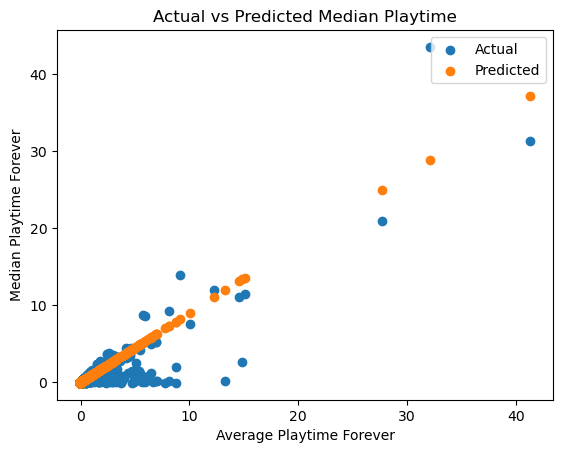

In [94]:
# Regression plot
plt.scatter(X_test, y_test, label='Actual')
plt.scatter(X_test, y_pred, label='Predicted')
plt.title('Actual vs Predicted Median Playtime')
plt.xlabel('Average Playtime Forever')
plt.ylabel('Median Playtime Forever')
plt.legend()
plt.show()

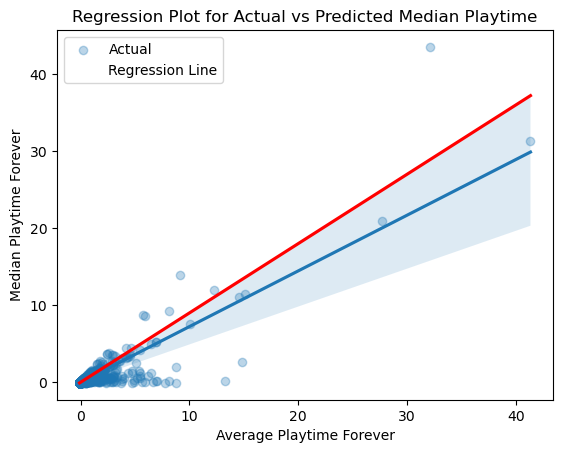

In [95]:
# Regression plot
sns.regplot(x=X_test, y=y_test, scatter_kws={'alpha': 0.3}, label='Actual')
sns.regplot(x=X_test, y=y_pred, scatter_kws={'alpha': 0}, line_kws={'color': 'red'}, label='Regression Line')
plt.title('Regression Plot for Actual vs Predicted Median Playtime')
plt.xlabel('Average Playtime Forever')
plt.ylabel('Median Playtime Forever')
plt.legend()
plt.show()

# 6. Price Influence
- *Theory*: User scores for games are typically higher when they are more expensive.
- *Analysis*: Examine average user scores for various price ranges of games.

In [97]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT 
                game.appid, 
                game.price, 
                user_feedback.user_score
            FROM game
            JOIN user_feedback ON game.appid = user_feedback.appid;'''
    query = text(txt)
    result = connection.execute(query)
    price_df = pd.DataFrame(result.all())

price_df

,appid,price,user_score
0,10,9.99,0.0
1,20,4.99,0.0
2,30,4.99,0.0
3,40,4.99,0.0
4,50,4.99,0.0
...,...,...,...
85098,2760980,0.00,0.0
85099,2761170,0.00,0.0
85100,2763480,0.00,0.0
85101,2764930,0.00,0.0


In [ ]:
# Fill NaN values with an empty string (if needed)
price_df = price_df.fillna('')

# Normalize numerical features using StandardScaler
numerical_columns = price_df.select_dtypes(include=['float64', 'int64']).columns.difference(['appid'])
scaler = StandardScaler()
price_df[numerical_columns] = scaler.fit_transform(price_df[numerical_columns])

In [98]:
# Split the data into features (X) and target variable (y)
X = price_df[['price']]
y = price_df['user_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Print the coefficients
print(f'Intercept: {model.intercept_}, Coefficient: {model.coef_}')

Mean Squared Error: 3.4017182793271217
R-squared: -1.794781250485933e-05
Intercept: 0.04232092438034673, Coefficient: [-0.00025108]


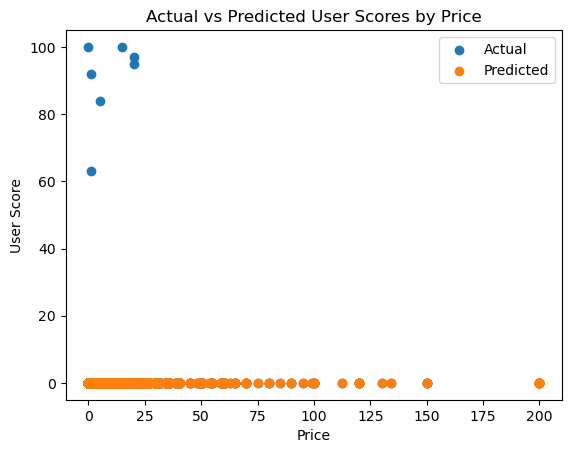

In [99]:
# Regression plot
plt.scatter(X_test, y_test, label='Actual')
plt.scatter(X_test, y_pred, label='Predicted')
plt.title('Actual vs Predicted User Scores by Price')
plt.xlabel('Price')
plt.ylabel('User Score')
plt.legend()
plt.show()

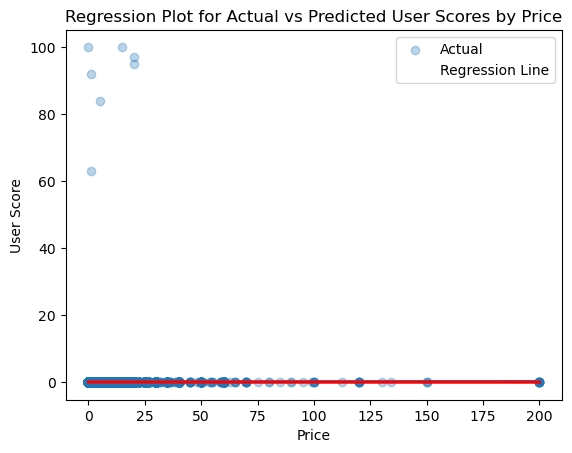

In [101]:
# Regression plot
sns.regplot(x=X_test, y=y_test, scatter_kws={'alpha': 0.3}, label='Actual')
sns.regplot(x=X_test, y=y_pred, scatter_kws={'alpha': 0}, line_kws={'color': 'red'}, label='Regression Line')
plt.title('Regression Plot for Actual vs Predicted User Scores by Price')
plt.xlabel('Price')
plt.ylabel('User Score')
plt.legend()
plt.show()

# 7. Categorization Impact on Popularity
- *Theory*: Owner estimates of games tend to be higher for those with more categories and genres.
- *Analysis*: Look at the connection between estimated owners and the number of categories/genres.

In [105]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT 
                game.appid, 
                game.estimated_owners, 
                categorization.categories, 
                categorization.genres
            FROM game
            JOIN categorization ON game.appid = categorization.appid;'''
    query = text(txt)
    result = connection.execute(query)
    category_df = pd.DataFrame(result.all())

category_df

,appid,estimated_owners,categories,genres
0,10,15000000.0,"Multi-player,PvP,Online PvP,Shared/Split Scree...",Action
1,20,7500000.0,"Multi-player,PvP,Online PvP,Shared/Split Scree...",Action
2,30,7500000.0,"Multi-player,Valve Anti-Cheat enabled",Action
3,40,7500000.0,"Multi-player,PvP,Online PvP,Shared/Split Scree...",Action
4,50,7500000.0,"Single-player,Multi-player,Valve Anti-Cheat en...",Action
...,...,...,...,...
85098,2760980,0.0,unknown,unknown
85099,2761170,0.0,unknown,unknown
85100,2763480,0.0,unknown,unknown
85101,2764930,0.0,unknown,unknown


In [106]:
# Download NLTK stopwords data
nltk.download('stopwords')

# Columns to convert to lists
columns_to_convert = [ 'categories', 'genres']

# Fill NaN values with an empty string
category_df[columns_to_convert] = category_df[columns_to_convert].fillna('')

# Normalize numerical features using StandardScaler
numerical_columns = category_df.select_dtypes(include=['float64', 'int64']).columns.difference(['appid'])
scaler = StandardScaler()
category_df[numerical_columns] = scaler.fit_transform(category_df[numerical_columns])

# One-hot encode categorical features
categorical_columns = category_df.select_dtypes(include=['bool']).columns.difference(['appid'])
category_df = pd.get_dummies(category_df, columns=categorical_columns, drop_first=True)

# Use CountVectorizer to convert text columns to bag-of-words representation
count_vectorizer = CountVectorizer(stop_words=stopwords.words('english'))  # Use English stopwords
for column in columns_to_convert:
    column_bow = count_vectorizer.fit_transform(category_df[column])
    category_df = pd.concat([category_df, pd.DataFrame(column_bow.toarray(), columns=count_vectorizer.get_feature_names_out([column]))], axis=1)
    category_df.drop(column, axis=1, inplace=True)

category_df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lualg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,appid,estimated_owners,achievements,anti,app,available,captions,cards,cheat,cloud,...,software,sports,strategy,training,tutorial,unknown,utilities,video,violent,web
0,10,14.511447,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,20,7.213937,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,30,7.213937,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,40,7.213937,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,50,7.213937,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85098,2760980,-0.083573,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
85099,2761170,-0.083573,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
85100,2763480,-0.083573,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
85101,2764930,-0.083573,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
